In [ ]:
path = '/content/taleoftwocities.txt'
with open(path, encoding='utf8', errors='ignore') as f:
  text = f.read().lower()

**Data Preprocessing and Visualization**


In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [ ]:
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import re
from keras.utils import to_categorical
from nltk.tokenize import RegexpTokenizer
cleaned = RegexpTokenizer(r'\w+')
tokens = cleaned.tokenize(text)
train_len = 3+1
text_sequences = []
for i in range(train_len,len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)
sequences = {}
count = 1
for i in range(len(tokens)):
    if tokens[i] not in sequences:
        sequences[tokens[i]] = count
        count += 1
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences) 
 
vocabulary_size = len(tokenizer.word_counts)+1

n_sequences = np.empty([len(sequences),train_len], dtype='int32')
for i in range(len(sequences)):
    n_sequences[i] = sequences[i]

Using TensorFlow backend.


In [ ]:
train_inputs = n_sequences[:,:-1]
train_targets = n_sequences[:,-1]
train_targets = to_categorical(train_targets, num_classes=vocabulary_size)
seq_len = train_inputs.shape[1]
train_inputs.shape

(138134, 3)

In [ ]:
nltk.download("popular")
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
WNL = nltk.WordNetLemmatizer()
text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\\-]", word)) for word in tokens ]
stopwords_wc = set(STOPWORDS)
text_content = [word for word in text_content if word not in stopwords_wc]
text_content = [s for s in text_content if len(s) != 0]
text_content = [WNL.lemmatize(t) for t in text_content]

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Pre- trained word embeddings(GLoVE)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-07-30 07:33:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-07-30 07:33:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-07-30 07:33:24--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
!unzip glove*.zip.1

Archive:  glove.6B.zip.1
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip    sample_data
glove.6B.200d.txt  glove.6B.50d.txt   glove.6B.zip.1  taleoftwocities.txt
/content


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import GlobalMaxPooling1D
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
import tensorflow as tf

#embedding layer

model = Sequential()
model.add(Embedding(vocabulary_size,300,weights=[embedding_matrix],input_length=seq_len,trainable=False)) 
model.add(LSTM(60,return_sequences=True))
model.add(LSTM(60))
model.add(Dense(60,activation='relu'))
model.add(Dense(vocabulary_size, activation='softmax'))
print(model.summary())

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
history = model.fit(train_inputs,train_targets,validation_split=0.1,epochs=20,batch_size=128,shuffle=True,callbacks=[callback])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3, 300)            2920200   
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 60)             86640     
_________________________________________________________________
lstm_4 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_4 (Dense)              (None, 9734)              593774    
Total params: 3,633,314
Trainable params: 713,114
Non-trainable params: 2,920,200
_________________________________________________________________
None
Train on 124320 samples, validate on 13814 samples
Epoch 1/20
124320/124320 [======================

In [ ]:
from keras.preprocessing.sequence import pad_sequences
input_text = input().strip().lower()
encoded_text = tokenizer.texts_to_sequences([input_text])[0]
pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
print(encoded_text, pad_encoded)
for i in (model.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
  pred_word = tokenizer.index_word[i]
  print("Next word suggestion:",pred_word)

there was a
[33, 12, 5] [[33 12  5]]
Next word suggestion: little
Next word suggestion: few
Next word suggestion: long


Model Evaluation

In [ ]:
model.evaluate(train_inputs,train_targets,verbose=0)

[4.745074044414187, 0.15740512311458588]

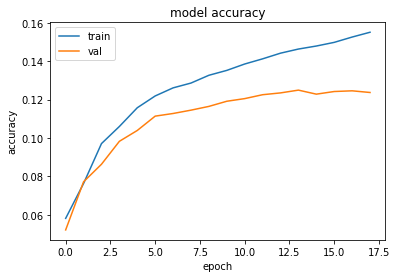

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


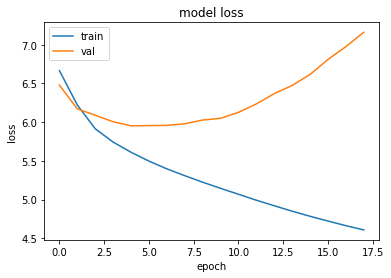

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')